<a href="https://colab.research.google.com/github/DDoesCode/Debanshi-Deb/blob/main/emojipredictionbiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import zipfile

# Replace 'twitter-emoji-prediction.zip' with the actual filename if different
with zipfile.ZipFile('/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('twitter_emoji_data')


In [8]:
import pandas as pd

# Load the training data
df = pd.read_csv('twitter_emoji_data/Train.csv')

# Display the first few rows
df.head()


,Unnamed: 0,TEXT,Label
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,2,Been friends since 7th grade. Look at us now w...,2
3,3,This is what it looks like when someone loves ...,3
4,4,RT @user this white family was invited to a Bl...,3


In [43]:
import pandas as pd

# Load the mapping CSV (export the Excel sheet as CSV first)
emoji_map = pd.read_csv('twitter_emoji_data/Mapping.csv')  # Update path if needed
number_to_emoji = emoji_map.set_index('number')['emoticons'].to_dict()


In [20]:
!pip install nltk --quiet

import numpy as np
import pandas as pd
import re, string
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Use TensorFlow's version of Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping



In [23]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download just what's needed (no punkt)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()  # Simpler tokenizer (no punkt needed)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['TEXT'].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
# STEP 4: Tokenize and Pad Sequences
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
max_len = 50
X = pad_sequences(sequences, maxlen=max_len)
y = df['Label'].values
num_classes = len(np.unique(y))


In [25]:
# STEP 5: Train-test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [26]:
# STEP 6: Load GloVe Embeddings
embedding_dim = 100
embedding_index = {}

with open("/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


In [27]:
# STEP 7: Prepare Embedding Matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
# STEP 8: Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [49]:
# STEP 9: Build BiLSTM Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     4,986,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,986,000 (19.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,986,000 (19.02 MB)

In [48]:
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))  # Unfreeze embeddings

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [51]:
# STEP 10: Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=128,
                    class_weight=class_weights,
                    callbacks=[early_stop])


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 126s 288ms/step - accuracy: 0.0993 - loss: 2.9053 - val_accuracy: 0.1570 - val_loss: 2.7510
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 143s 291ms/step - accuracy: 0.1560 - loss: 2.7069 - val_accuracy: 0.1749 - val_loss: 2.6862
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 143s 293ms/step - accuracy: 0.1655 - loss: 2.6532 - val_accuracy: 0.1727 - val_loss: 2.6951
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 136s 280ms/step - accuracy: 0.1791 - loss: 2.5943 - val_accuracy: 0.1724 - val_loss: 2.6974
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 123s 280ms/step - accuracy: 0.1846 - loss: 2.5791 - val_accuracy: 0.1961 - val_loss: 2.6456
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 280ms/step - accuracy: 0.1941 - loss: 2.5484 - val_accuracy: 0.1879 - val_loss: 2.6509
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 147s 293ms/step - accuracy: 0.2004 - loss: 2.5263 - val_accuracy: 0.1957 - val_loss: 2.6315
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 127s 290ms/step - accuracy: 0.2025 -

In [52]:
# STEP 11: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.1817 - loss: 2.6439
Test Accuracy: 0.1880


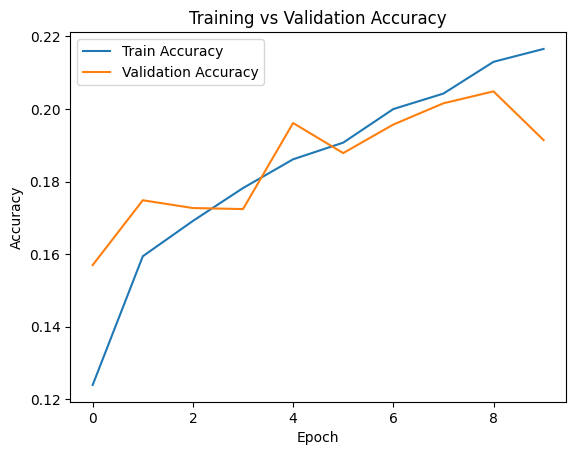

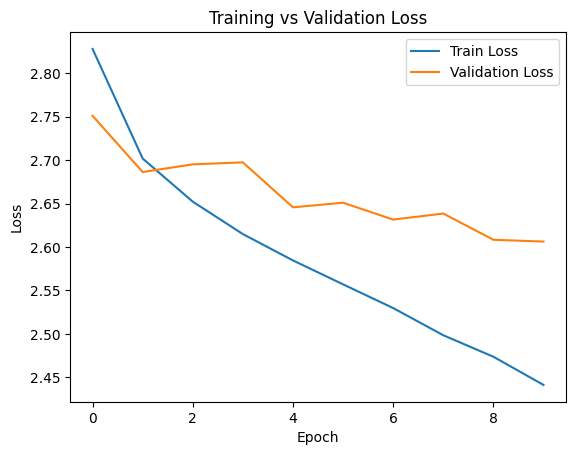

In [54]:
# STEP 12: Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
def predict_emoji(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded, verbose=0)
    label = np.argmax(pred)
    return number_to_emoji.get(label, "❓")


In [1]:
print("Prediction:", predict_emoji("I'm feeling great today!"))
print("Prediction:", predict_emoji("This made me cry."))
print("Prediction:", predict_emoji("You're so funny lol"))
print("Prediction:", predict_emoji("I hate everything!"))
print("Prediction:", predict_emoji("What a lovely gift!"))
print("Prediction:", predict_emoji("Wait, what?! No way!"))


NameError: name 'predict_emoji' is not defined